In [1]:
import numpy as np
import math
from scipy.optimize import minimize  

# Accelerated Gradient Sliding

##### Katyusha

In [36]:
def orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh):
    nor1 = np.linalg.norm(x - ksik, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - ksi0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(ksik).T, x - ksik)) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2

In [37]:
def orac_z(x, alpha, p_orac_psi_kat, zk, gr_tilde, ksik, ksi0, p_grad_h, L, Lh):
    
    nor1 = np.linalg.norm(x - zk, 2)
    nor_sq1 = nor1*nor1

    return 1 / 2 / alpha * nor_sq1  + float(np.dot(gr_tilde.T, x)) + p_orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh)

In [105]:
def Katyusha(x0, S_n, L, p_grad_h, p_grad_g, p_stoch_grad, p_orac_z, eps, p_h, Lh, ksik, ksi0, p_orac_psi_kat):
    n_dim = x0.shape[0]
    n_sam = n_dim - 1
    m = 3#2 * n_sam
    tau2 = 0.5
    n = n_sam
 
    y = np.copy(x0)
    z = np.copy(x0)
    x_tilde = np.copy(x0)
    
    for i in range(0, S_n):
        grad_mu = n * p_grad_g(x_tilde)
        tau1 = 2 / (i + 4)
        
        alpha = 1 / 3 / tau1 / L
        
        sum_y = 0
        
        for j in range(0, m):
            k = s * m + j
            x = tau1 * z + tau2 * x_tilde + (1 - tau1 - tau2) * y
            a = np.random.randint(0, n_sam) 
            grad_x = n * p_stoch_grad(x, a)
            grad_x_tilde = n * p_stoch_grad(x_tilde, a)
            grad_t = grad_mu + grad_x - grad_x_tilde
            z_new = np.copy(z)
            
            
            allargs = (alpha, p_orac_psi_kat, z, grad_t, ksik, ksi0, p_grad_h, L, Lh)
            minim_res = minimize(p_orac_z, args = allargs, x0 = np.ravel(z), tol = eps, options={'maxiter': 15, 'disp': False})
            print('j inside Kat', j)
            z_new = minim_res.x
            y = x + tau1 * (z_new - z)
            z = z_new
            
            sum_y = sum_y + y
        x_tilde = 1 / m * sum_y    
    return x_tilde

##### Gradient Method for Composite Optimization
 

$\phi_{i}(y) := \langle \nabla h(y^{k}), \, y - y^{k} \rangle + g(y) + \tfrac{L_h}{2} \|y - y^{k}\|_2^2 + \tfrac{L}{2} \|y - y^{0}\|_2^2$

In [73]:
# Psi function
# Input parameters:
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# yk --- y^{k}
# L_h  --- Lipchitz for h(x)

def orac_psi(x, p_grad_h, p_g, Lh, yk, L, y0):
    
    nor1 = np.linalg.norm(x - yk, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - y0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(yk).T, x - yk)) + p_g(x) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2


# Gradient Method for Composite Optimization
# Input parameters:
# p_orac_psi --- oracle for Minimization Alg
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# y0 --- y^0 (first initial point for minimize)
# L_h  --- Lipchitz for h(x)
# N --- number of iterations
# xk1 --- $x^{k+1}$

def GradComposite(p_orac_psi, p_grad_h, p_g, Lh, y0, N, L, xk1, p_grad_g, eps, p_stoch_grad, p_h, p_orac_psi_kat):
    
    yi = np.copy(xk1)
    nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi), 2)
    nor2_krit = 0
    
    i = 0
    
    while True:#for i in range(0, N):
        
        i = i + 1
        
        allargs = (p_grad_h, p_g, Lh, yi, L, y0)
        
        print('minimize start', yi.shape, y0.shape)
        
        yi = Katyusha(yi, 1, L, p_grad_h, p_grad_g, p_stoch_grad, orac_z, eps, p_h, Lh, yi, y0, p_orac_psi_kat)
        #minim_res = minimize(p_orac_psi, args = allargs, x0 = np.ravel(yi), tol = eps, options={'maxiter': 10, 'disp': True})
        print('minimize fin')

        nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi) + L*(yi - y0), 2)
        nor2_krit = np.linalg.norm(yi - y0, 2)
        
        print('Comp', i, nor1_krit)  
        
        if nor1_krit <= L / 2 * nor2_krit:
            break
        
        if i > 0:
            break
    
    return yi#sum_y / N

#### Monteiro–Svaiter Accelerated Proximal method
Parameters:  
$L > 0$    
$x0$ --- initial point  
$N$ --- number of iterations  
$type\_z\_step$ --- 1 -- stardard version for calculating $z$, 2 -- experimental version for calculating $z$ (without gradient of $f(x)$)   

In [47]:
def ms_acc_prox_method(L, Lh, x0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, eps, p_stoch_grad, p_h, verbose = 0):

    # Initial points
    y0 = np.copy(x0)
    z0 = np.copy(x0)

    it = 0

    x = x0
    y = y0
    z = z0

    plt1 = []
    
    Ak = 0
    
    while  it < N: 
        it = it + 1
        
        ak = (1/L + math.sqrt(1/L/L + 4 * Ak / L)) / 2
        Ak1 = Ak + ak
        
        x = Ak / Ak1 * y + ak / Ak1 * z
        
        #print('mm', x.shape, y.shape, z.shape)
        y = GradComposite(orac_psi, p_grad_h, p_g, Lh, x, N, L, x, p_grad_g, eps, p_stoch_grad, p_h, orac_psi_kat)
        
        if type_z_step == 1:
            z = z - ak * (p_grad_h(y) + p_grad_g(y))
        elif type_z_step == 2:    
            z = z - ak * L * (x - y)
        
        if verbose == 1:
            print("x y z ak Ak Ak+1", x.shape, y.shape, z.shape, ak, Ak, Ak1)
        
        Ak = Ak1
     

        
        if verbose == 1:
            print('Main loop: iter f(y)')

        plt1.append(p_f(y))
        
        if verbose == 1:
            print(it, p_f(y))
        
    return N, y, plt1

##### Restarts for MS

In [7]:
def ms_restarts(mu, L, Lh, eta0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, verbose = 0):
    
    N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, verbose = 1)
    

https://arxiv.org/pdf/1804.02579.pdf


#### Case 1. Kernel SVM

In [8]:
import pandas as pd
# Load data from a csv file
bcdf = pd.read_csv('breast-cancer-wisconsin.data', header = None)

# Drop unecessary columns
bcdf.drop([0], axis = 1, inplace = True)

print(bcdf.size)
bcdf.replace('?', np.nan, inplace = True)
bcdf.dropna(inplace = True)
print(bcdf.size)

bcdf[10].replace(2, 1, inplace = True)
bcdf[10].replace(4, -1, inplace = True)

bcdf = bcdf.apply(pd.to_numeric, errors = 'ignore')
bcdf.info()

6990
6830
<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
1     683 non-null int64
2     683 non-null int64
3     683 non-null int64
4     683 non-null int64
5     683 non-null int64
6     683 non-null int64
7     683 non-null int64
8     683 non-null int64
9     683 non-null int64
10    683 non-null int64
dtypes: int64(10)
memory usage: 58.7 KB


In [9]:
bcdf.groupby(10).mean()

,1,2,3,4,5,6,7,8,9
10,,,,,,,,,
-1,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510
1,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315


In [10]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split data into testing and training set. Use 67% for training
X_train, X_test, y_train, y_test = train_test_split(bcdf.iloc[:,:-1], bcdf[10], train_size = .67)

# Instantiate 
norm = Normalizer()

# Fit
norm.fit(X_train)

# Transform both training and testing sets
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}

kfold = KFold(n_splits = 5, shuffle = True)#, random_state = 42)

model_grid = GridSearchCV(SVC(), SVM_params)

cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv = kfold, scoring = 'accuracy')

msg = "Cross Validation Accuracy %s: Accuracy: %f SD: %f" % ('SVM sklearn', cv_results.mean(), cv_results.std())

print(msg)

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will ch

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

Cross Validation Accuracy SVM sklearn: Accuracy: 0.872957 SD: 0.036176


C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

$$
\min_{\beta_0, \, \beta} \sum_{i = 1}^n [1 - y_i (\beta_0 + \beta x_i)]_+ + \frac{\lambda}{2} \| \beta \|_2
$$

$$
\min_{\beta_0, \, \theta} L[y, \, K \theta] + \frac{\lambda}{2} \theta^T K \theta
$$

$K$ is $n \times n$ matrix, $K(x, x') = \exp(-\gamma \|x - x' \|^2)$

In [11]:
pd.to_numeric(X_train[6])

664     1
203     1
159    10
173    10
552     1
286    10
544     1
575     1
1      10
601     1
663     1
0       1
96      1
574     2
359     7
136     1
318     1
677     1
79      1
682     1
539     1
347     1
400     9
219     1
453    10
210    10
314     1
374     1
426     1
434     8
       ..
325     1
609     1
186     8
134     1
3       4
680    10
518     1
185     1
551     1
60      3
477     1
429     1
41      3
485     3
82      1
614     1
80      1
471     1
523    10
414    10
600     1
184    10
363     3
578     1
447     1
461     5
71      2
166    10
344    10
237     2
Name: 6, Length: 457, dtype: int64

In [102]:
# Oracles

# h(x) is strongly convex

lam = 0.1
gamma = 1

n_sam = X_train.values.shape[0]
X_arr = X_train.values
y_arr = y_train.values.reshape(n_sam, 1)

def K_func(xi, xj):
    nor = np.linalg.norm(xi - xj, 2)
    #xi = xi.reshape(xi.shape[0], 1)
    #r = np.dot(xi.T, xj)
    #return (1+r)*(1+r)
    return np.exp(-gamma * nor * nor)

K_matrix = np.zeros((n_sam, n_sam))
E_matrix = np.identity(n_sam)
for i in range(0, n_sam):
    for j in range(0, n_sam):
        K_matrix[i][j] = K_func(X_arr[i, :], X_arr[j, :])

def h1(btheta):
    theta = btheta[1:] #bnorm = np.linalg.norm(beta[1:])
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    #print('h1', lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta))))
    return lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta)))

def grad_h1(btheta):
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    gr = lam*np.dot(K_matrix, theta)
    #print('gr', gr.shape)
    gr0 = np.insert(gr, 0, 0)#, axis = 0)
    #print('gr h1', gr0.shape, np.linalg.norm(gr), gr[3], theta[3])
    return gr0 

def g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    #theta = theta.reshape(n_dim, 1)
    
    beta0 = btheta[0]
    
    s2 = 0
    
    for i in range(0, n_dim):
                      
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            pos = 1 - ty - mu_n / 2
        elif ty <= 1:
            pos = (1 - ty) * (1 - ty) / 2 / mu_n
        else:
            pos = 0
        s2 = s2 + pos  
        
    return float(s2)

def grad_g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = btheta[0]
    
    gr = np.zeros(btheta.shape)#.reshape(n_dim, 1)    
        
    sum_for_beta0 = 0
    sum_for_beta = 0
    for i in range(0, n_dim):
        #print(theta.T.shape, K_matrix[i, :].reshape(n_dim, 1).shape)
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[i])
            for_beta = for_beta0*K_matrix[i, :]
            #print(ty, for_beta0.shape, for_beta.shape)
        elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[i]))
            for_beta = for_beta0 * K_matrix[i, :]
        else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
        sum_for_beta0 = sum_for_beta0 + for_beta0
        sum_for_beta = sum_for_beta + for_beta
        #print(i, ty, sum_for_beta0, sum_for_beta.shape, np.linalg.norm(sum_for_beta))
    gr[0] = sum_for_beta0
    gr[1:] = sum_for_beta
    
    return gr
    
def f1(x):
    return h1(x) + g1(x)

def f2(x):
    return h(x) + g1(x)

def stoch_grad(x, a):
    
    theta = x[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = x[0]
    
    gr = np.zeros(x.shape)#.reshape(n_dim, 1)    
        
    ty = y_arr[a]*(beta0 + float(np.dot(theta.T, K_matrix[a, :].reshape(n_dim, 1))))
    ty = float(ty)
        
    if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[a])
            for_beta = for_beta0*K_matrix[a, :]
            #print(ty, for_beta0.shape, for_beta.shape)
    elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[a]))
            for_beta = for_beta0 * K_matrix[a, :]
    else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
    gr[0] = for_beta0
    gr[1:] = for_beta
    
    return gr        

In [109]:
n_sam = X_arr.shape[0]
n = 10
x0 = 10*np.random.rand(n_sam + 1)

import scipy
w, v = scipy.linalg.eig(K_matrix)
Lh = int(np.max(w)) + 1

print("L_h = ", Lh)
L = Lh*n_sam

eps = 1e-1
mu_n = eps # Parameter for Nesterov's smoothing

norm_x0 = np.linalg.norm(x0, 2)
s = sum([np.linalg.norm(X_arr[i], 2) for i in range(0, n_sam)])
norm_opt = min([1 / n_sam / lam*s, math.sqrt(2/lam)])
norm_x0


T = math.log((norm_x0*norm_x0 + norm_opt*norm_opt + 2*norm_x0*norm_opt) * mu / eps)

N0 = math.sqrt(8 * L / mu)
N0

L_h =  25


C:\Users\Jane\AnacondaPython\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


302.32432915661946

In [35]:
N_minn = math.log(1/eps)

In [114]:
N = 2000

N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, eps, stoch_grad, h1, verbose = 1)

#print('----------------------------------------------------------------')
#N2, y2, plt2 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 2, eps, stoch_grad, h1, verbose = 1)

print('Answer 1: ', N1, f1(y1))
#print('Answer 2: ', N2, f1(y2))

minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23080.431192176933
x y z ak Ak Ak+1 (458,) (458,) (458,) 8.7527352297593e-05 0 8.7527352297593e-05
Main loop: iter f(y)
1 7609.710725749762
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23076.761985967325
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.00014162223096279166 8.7527352297593e-05 0.00022914958326038465
Main loop: iter f(y)
2 7477.230482486705
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23069.068603672065
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.00019199361797208347 0.00022914958326038465 0.0004211432012324681
Main loop: iter f(y)
3 7347.147079784572
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23003.08136540249
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.00024068195537159257 0.0004211432012324681 0.0006618251566040607
Main loop: iter f(y)
4 7219.378

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8384.984750526417
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0015505589102010353 0.025917802360792636 0.027468361270993672
Main loop: iter f(y)
33 5526.936704560138
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8092.34789314101
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0015949400662972153 0.027468361270993672 0.029063301337290886
Main loop: iter f(y)
34 5509.189970232313
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8088.545932150509
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0016393040468164338 0.029063301337290886 0.03070260538410732
Main loop: iter f(y)
35 5490.4580340057155
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7838.6855021407155
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0016836517873499216 0.03070260538410732 0.03238625717145724
Main loop: iter f(y)
36 5471.533271238545
minimiz

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4048.826827399339
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0030092691258866706 0.1004521110518816 0.10346138017776828
Main loop: iter f(y)
66 4748.3727137066535
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3993.69381727663
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0030533510118752054 0.10346138017776828 0.10651473118964348
Main loop: iter f(y)
67 4719.780537824122
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3931.066945846407
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0030974283042750415 0.10651473118964348 0.10961215949391852
Main loop: iter f(y)
68 4690.956380725714
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3872.6729987877734
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0031415011342743582 0.10961215949391852 0.11275366062819288
Main loop: iter f(y)
69 4661.906957149759
minimize star

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2595.610421746726
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.004462090026857865 0.2230124866070792 0.22747457663393705
Main loop: iter f(y)
99 3720.8701401824337
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2563.3939423013453
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0045060683124476765 0.22747457663393705 0.23198064494638473
Main loop: iter f(y)
100 3688.2499425614305
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2537.9230181655626
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.004550044503593432 0.23198064494638473 0.23653068944997815
Main loop: iter f(y)
101 3655.612664354332
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2516.8722790958373
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.004594018640876691 0.23653068944997815 0.24112470809085484
Main loop: iter f(y)
102 3622.9611998703467
minimize

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2039.647926826891
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.00591244979161698 0.39347198970950786 0.39938443950112484
Main loop: iter f(y)
132 2668.0697528307574
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2054.8965449108473
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.005956375433886803 0.39938443950112484 0.4053408149350117
Main loop: iter f(y)
133 2637.922486229001
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2013.0065388031749
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.006000299881760264 0.4053408149350117 0.41134111481677194
Main loop: iter f(y)
134 2607.9516323547027
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2042.8795464971604
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.006044223152755759 0.41134111481677194 0.4173853379695277
Main loop: iter f(y)
135 2578.1618418706216
minimize st

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3016.791006996433
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0073614475051338646 0.6117696920567315 0.6191311395618654
Main loop: iter f(y)
165 1777.992840879128
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1243.94677246954
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.007405341267276371 0.6191311395618654 0.6265364808291417
Main loop: iter f(y)
166 1754.3085780224221
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3117.514884787974
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.007449234258372215 0.6265364808291417 0.6339857150875139
Main loop: iter f(y)
167 1732.1159323289637
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1252.5161389089403
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.007493126487521075 0.6339857150875139 0.641478841575035
Main loop: iter f(y)
168 1708.9171087400978
minimize start (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1233.7601650646905
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.008809578414403992 0.8778694973522575 0.8866790757666615
Main loop: iter f(y)
198 1153.6951331833786
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3027.598749557832
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.008853450793117413 0.8866790757666615 0.8955325265597789
Main loop: iter f(y)
199 1139.889892290924
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1246.3465398560447
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.00889732263317288 0.8955325265597789 0.9044298491929518
Main loop: iter f(y)
200 1125.0235925575826
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3000.910071525203
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.008941193939889023 0.9044298491929518 0.9133710431328408
Main loop: iter f(y)
201 1111.7162837787484
minimize start (4

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3223.640672005313
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.010257108636153641 1.1917474626451694 1.202004571281323
Main loop: iter f(y)
231 815.5285636325625
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7295.884919345482
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.010300965674413609 1.202004571281323 1.2123055369557365
Main loop: iter f(y)
232 813.3826277057547
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4018.5960905698007
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.010344822315181848 1.2123055369557365 1.2226503592709184
Main loop: iter f(y)
233 805.2552196669535
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1515.770034954066
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.010388678561832216 1.2226503592709184 1.2330390378327505
Main loop: iter f(y)
234 798.9595711754619
minimize start (458,) 

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1537.3867656769323
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.011704197835265946 1.553386523763212 1.565090721598478
Main loop: iter f(y)
264 671.3702499750015
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7041.234038096658
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01174804333046303 1.565090721598478 1.576838764928941
Main loop: iter f(y)
265 669.3884486306707
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2970.314552876411
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01179188852030103 1.576838764928941 1.588630653449242
Main loop: iter f(y)
266 665.9198158548552
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5248.005417238305
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.011835733407052844 1.588630653449242 1.600466386856295
Main loop: iter f(y)
267 663.4645600448738
minimize start (458,) (458,)
j

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5491.151112612124
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.013150949394674816 1.9627738951416533 1.9759248445363282
Main loop: iter f(y)
297 583.6558093439867
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10467.36897394538
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.013194785888914158 1.9759248445363282 1.9891196304252423
Main loop: iter f(y)
298 587.5951282970946
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5197.74266899345
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.013238622141234288 1.9891196304252423 2.0023582525664767
Main loop: iter f(y)
299 580.8306361808171
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2403.7276741643095
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.013282458153238627 2.0023582525664767 2.0156407107197154
Main loop: iter f(y)
300 577.0775323452034
minimize start (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6246.661103234899
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01459743411518271 2.419899636270435 2.4344970703856177
Main loop: iter f(y)
330 517.0304707234621
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2244.6185411556967
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.014641263393787091 2.4344970703856177 2.4491383337794046
Main loop: iter f(y)
331 513.0303724793795
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1779.8869488893401
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.014685092476008457 2.4491383337794046 2.463823426255413
Main loop: iter f(y)
332 510.639199465767
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1812.7952121168614
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.014728921363019927 2.463823426255413 2.478552347618433
Main loop: iter f(y)
333 508.3682822834411
minimize start (458,) (4

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3084.2370018499123
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01604370261802601 2.924755795354829 2.9407994979728547
Main loop: iter f(y)
363 456.784338596179
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1743.762767820752
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.016087525982883606 2.9407994979728547 2.9568870239557383
Main loop: iter f(y)
364 454.4190900847998
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1725.9444129926721
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.016131349185146263 2.9568870239557383 2.9730183731408846
Main loop: iter f(y)
365 452.00263412558513
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8827.19397609818
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.016175172225697997 2.9730183731408846 2.9891935453665828
Main loop: iter f(y)
366 451.31417735754843
minimize start (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5710.597245210398
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.017489792354461547 3.4773358658254647 3.494825658179926
Main loop: iter f(y)
396 409.21348109903766
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 28686.49769867072
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.017533610784157824 3.494825658179926 3.512359268964084
Main loop: iter f(y)
397 475.22134445324707
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12390.994484098639
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01757742907701936 3.512359268964084 3.5299366980411033
Main loop: iter f(y)
398 410.2768152193454
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1786.9910378964744
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01762124723372881 3.5299366980411033 3.547557945274832
Main loop: iter f(y)
399 406.20160435894957
minimize start (458,) (

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7719.800038724288
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.018935731812977273 4.077634424609544 4.096570156422521
Main loop: iter f(y)
429 363.980171269211
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17462.893017002953
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.018979546061684116 4.096570156422521 4.115549702484205
Main loop: iter f(y)
430 387.149838531054
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 11349.96150041708
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.019023360193644607 4.115549702484205 4.134573062677849
Main loop: iter f(y)
431 364.045238744964
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6064.144609424206
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.01906717420939683 4.134573062677849 4.153640236887246
Main loop: iter f(y)
432 353.5322091651229
minimize start (458,) (458,)
j i

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7397.2156559387895
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.020381543169758827 4.725646881960227 4.746028425129985
Main loop: iter f(y)
462 324.31994472674916
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8524.34040931467
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02042535383099424 4.746028425129985 4.7664537789609795
Main loop: iter f(y)
463 315.4665633692182
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5286.262274554515
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.020469164391450835 4.7664537789609795 4.7869229433524305
Main loop: iter f(y)
464 316.4971701519207
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 9246.939539978031
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.020512974851560246 4.7869229433524305 4.807435918203991
Main loop: iter f(y)
465 318.4938299786485
minimize start (458,) (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1844.6738236751933
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02182724402634791 5.421369302875737 5.443196546902085
Main loop: iter f(y)
495 280.8908980900752
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3353.6080653849276
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.021871051575589957 5.443196546902085 5.465067598477675
Main loop: iter f(y)
496 276.10757432267826
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3121.413563523161
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02191485903695471 5.465067598477675 5.48698245751463
Main loop: iter f(y)
497 280.44877133989013
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5222.249462125703
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.021958666410793675 5.48698245751463 5.508941123925424
Main loop: iter f(y)
498 287.74603005082116
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1784.2336896451925
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.023272848587588543 6.164798276188304 6.188071124775892
Main loop: iter f(y)
528 254.50014155019792
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1801.8090393401512
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02331665341163657 6.188071124775892 6.211387778187528
Main loop: iter f(y)
529 251.89449037963593
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2204.8133071325633
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.023360458158380476 6.211387778187528 6.234748236345909
Main loop: iter f(y)
530 249.64310942799042
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3277.4389353383435
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02340426282811032 6.234748236345909 6.258152499174019
Main loop: iter f(y)
531 250.48753626503535
minimize start (458,) (

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 996.8043030972243
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0247183684831983 6.95593081639993 6.980649184883129
Main loop: iter f(y)
561 220.10922669391317
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19092.934279649628
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.024762170900938203 6.980649184883129 7.005411355784067
Main loop: iter f(y)
562 284.9112034335878
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14411.466675049698
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02480597325014725 7.005411355784067 7.030217329034214
Main loop: iter f(y)
563 238.8130544169071
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 13067.458793450356
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.024849775531067573 7.030217329034214 7.055067104565281
Main loop: iter f(y)
564 233.47576202039286
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8215.081188805772
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.026163813355010536 7.794764288621322 7.820928101976333
Main loop: iter f(y)
594 209.88485216498867
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 95.172406918393
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.026207613632437298 7.820928101976333 7.84713571560877
Main loop: iter f(y)
595 206.9808862864386
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1138.2868417666032
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.026251413848693138 7.84713571560877 7.8733871294574636
Main loop: iter f(y)
596 204.4596390463699
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3840.3635516910867
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.026295214003982267 7.8733871294574636 7.899682343461445
Main loop: iter f(y)
597 202.70832470617106
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5111.1222186333625
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.027609191285788735 8.681296350190701 8.70890554147649
Main loop: iter f(y)
627 176.7592763096439
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 924.052632594024
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.027652989647092327 8.70890554147649 8.736558531123583
Main loop: iter f(y)
628 174.90316899574967
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20950.331262051404
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.027696787953459687 8.736558531123583 8.764255319077042
Main loop: iter f(y)
629 234.5397790775574
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14694.2201647949
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.02774058620506463 8.764255319077042 8.791995905282107
Main loop: iter f(y)
630 202.92927978870597
minimize start (458,) (458,)
j

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2964.7293963187803
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.029054509118292292 9.615524904580532 9.644579413698825
Main loop: iter f(y)
660 157.56743995080797
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5060.986731406007
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.029098305754183342 9.644579413698825 9.673677719453009
Main loop: iter f(y)
661 156.9922542287789
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1078.3912467875332
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.029142102340465863 9.673677719453009 9.702819821793474
Main loop: iter f(y)
662 155.21847045122357
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 11894.651363710904
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.029185898877289018 9.702819821793474 9.732005720670763
Main loop: iter f(y)
663 166.03603703752117
minimize start (458,) (

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4003.435912673362
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03049977269666836 10.597448064519222 10.62794783721589
Main loop: iter f(y)
693 143.66720040579486
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2359.080633971925
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.030543567770729255 10.62794783721589 10.65849140498662
Main loop: iter f(y)
694 141.44661368706116
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4498.37284553051
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.030587362799770115 10.65849140498662 10.68907876778639
Main loop: iter f(y)
695 139.6998978772171
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10947.167297792615
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.030631157783919904 10.68907876778639 10.71970992557031
Main loop: iter f(y)
696 140.90684903815358
minimize start (458,) (458

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5.737969463222273
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.031944987051813055 11.627064122133442 11.659009109185256
Main loop: iter f(y)
726 119.22354043450964
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5122.17257127214
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03198878070541103 11.659009109185256 11.690997889890667
Main loop: iter f(y)
727 118.83060979762249
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3895.0868666780116
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03203257431796896 11.690997889890667 11.723030464208636
Main loop: iter f(y)
728 117.91600326718084
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10525.130045075168
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.032076367889599104 11.723030464208636 11.755106832098235
Main loop: iter f(y)
729 121.37479484590476
minimize start (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 451.154203879836
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03339015654562016 12.704371524515537 12.737761681061157
Main loop: iter f(y)
759 104.67920134927
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17580.689064152248
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.033433948901756196 12.737761681061157 12.771195629962913
Main loop: iter f(y)
760 131.2863029140195
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6.140352560427071
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03347774122032673 12.771195629962913 12.80467337118324
Main loop: iter f(y)
761 106.4549067770292
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1510.084348785025
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03352153350143007 12.80467337118324 12.83819490468467
Main loop: iter f(y)
762 104.61050477594074
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8293.069816981724
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03483528498459755 13.829368853537009 13.864204138521606
Main loop: iter f(y)
792 93.98704110599385
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1136.5251796772905
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03487907615095628 13.864204138521606 13.899083214672562
Main loop: iter f(y)
793 92.20871498954885
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21416.608271193945
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03492286728280069 13.899083214672562 13.934006081955362
Main loop: iter f(y)
794 154.70959882289554
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 9076.129564757663
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03496665838021737 13.934006081955362 13.968972740335579
Main loop: iter f(y)
795 95.14376594381042
minimize start (458,) 

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 255.47904661835565
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03628037571034092 15.002054809023596 15.038335184733937
Main loop: iter f(y)
825 87.24598435961799
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10915.932851146254
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.036324165781732545 15.038335184733937 15.074659350515669
Main loop: iter f(y)
826 85.79423298293804
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 946.700258546434
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03636795582130379 15.074659350515669 15.111027306336972
Main loop: iter f(y)
827 83.60264007826805
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21432.72352959669
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0364117458291313 15.111027306336972 15.147439052166103
Main loop: iter f(y)
828 120.45544001753541
minimize start (458,) (

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 31349.399646231494
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.037725431672301246 16.22242819461999 16.26015362629229
Main loop: iter f(y)
858 197.07434473439267
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19863.011899727917
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.037769220732635465 16.26015362629229 16.297922847024925
Main loop: iter f(y)
859 115.92843475792881
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21186.405284927067
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.037813009763539664 16.297922847024925 16.335735856788464
Main loop: iter f(y)
860 82.3260316330753
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1175.5252291588185
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.037856798765082036 16.335735856788464 16.373592655553544
Main loop: iter f(y)
861 79.80233587811773
minimize start (458

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 501.36371118477024
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03917045548684856 17.490487905827234 17.52965836131408
Main loop: iter f(y)
891 65.04379307566525
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 37175.19211620635
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.03921424361074411 17.52965836131408 17.568872604924824
Main loop: iter f(y)
892 238.58246580415374
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 22565.57765683352
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0392580317073404 17.568872604924824 17.608130636632165
Main loop: iter f(y)
893 99.6692972540564
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20503.271807285408
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.039301819776698325 17.608130636632165 17.647432456408865
Main loop: iter f(y)
894 74.91366343109058
minimize start (458,) (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1309.35598255568
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04061544948561698 18.806232919810583 18.8468483692962
Main loop: iter f(y)
924 68.38425176656607
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 15743.646891662065
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04065923673972464 18.8468483692962 18.887507606035925
Main loop: iter f(y)
925 66.93586337612614
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 426.4450673288463
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04070302396844044 18.887507606035925 18.928210630004365
Main loop: iter f(y)
926 64.39687177770679
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21807.065671920438
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04074681117181903 18.928210630004365 18.968957441176183
Main loop: iter f(y)
927 69.44755643630799
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 22212.272284882314
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04206041575538383 20.169662286661943 20.211722702417326
Main loop: iter f(y)
957 80.68611410946892
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.781884454697355
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04210420219948198 20.211722702417326 20.25382690461681
Main loop: iter f(y)
958 56.57923876506923
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1200.2193669718977
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.042147988619902516 20.25382690461681 20.29597489323671
Main loop: iter f(y)
959 54.86000334972776
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 45699.775870211866
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04219177501669465 20.29597489323671 20.338166668253404
Main loop: iter f(y)
960 254.54198067879602
minimize start (458,) (4

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 788.5796135322421
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.043505356171202096 21.580775121866314 21.624280478037516
Main loop: iter f(y)
990 52.0750620998956
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 34105.98383690556
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.043549141859110296 21.624280478037516 21.667829619896626
Main loop: iter f(y)
991 139.86066880863908
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 2453.977066354515
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.043592927524887186 21.667829619896626 21.711422547421513
Main loop: iter f(y)
992 57.904108886506066
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5.362545728758255
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.043636713168577236 21.711422547421513 21.75505926059009
Main loop: iter f(y)
993 55.25124715119409
minimize start (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.883137667072475
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0449502724241112 23.039570599771583 23.084520872195693
Main loop: iter f(y)
1023 50.88234903001501
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14694.514537934276
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04499405740445675 23.084520872195693 23.12951492960015
Main loop: iter f(y)
1024 50.09729808151507
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.238642625832819
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0450378423640706 23.12951492960015 23.17455277196422
Main loop: iter f(y)
1025 47.97224595849062
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 36927.63986268665
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.045081627302993074 23.17455277196422 23.21963439926721
Main loop: iter f(y)
1026 162.39540321000632
minimize start (458,) (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12460.310370855994
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04639516604445697 24.546047947900014 24.592443113944473
Main loop: iter f(y)
1056 47.38222833561056
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1167.2134439276583
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04643895036132211 24.592443113944473 24.638882064305793
Main loop: iter f(y)
1057 45.54596164406684
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 48464.46767900283
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.046482734658726446 24.638882064305793 24.68536479896452
Main loop: iter f(y)
1058 227.34538830452982
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21578.722514342582
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04652651893670665 24.68536479896452 24.731891317901226
Main loop: iter f(y)
1059 68.56999002436416
minimize start (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17057.50689165362
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.047840038421630565 26.10020644197016 26.148046480391788
Main loop: iter f(y)
1089 53.91405720458876
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12433.510152353552
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0478838221151018 26.148046480391788 26.195930302506888
Main loop: iter f(y)
1090 51.51216032238204
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7433.948015033961
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.047927605790269744 26.195930302506888 26.24385790829716
Main loop: iter f(y)
1091 49.04310505504549
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12912.842925127792
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04797138944716783 26.24385790829716 26.291829297744325
Main loop: iter f(y)
1092 47.278662994249544
minimize start (458,

1121 44.63224078917123
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23021.398619110874
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04928489082086619 27.70204540152134 27.751330292342207
Main loop: iter f(y)
1122 55.86493972061893
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.521312112440174
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.049328673927503126 27.751330292342207 27.800658966269708
Main loop: iter f(y)
1123 44.48288065247059
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16826.184360832107
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04937245701689396 27.800658966269708 27.8500314232866
Main loop: iter f(y)
1124 45.6047722686352
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3.900965822703298
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.04941624008906931 27.8500314232866 27.89944766337567
Main loop: iter f

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10246.220012543226
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05072972439760872 29.351564186052467 29.402293910450076
Main loop: iter f(y)
1155 48.09767286819887
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10165.065994689687
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05077350695084601 29.402293910450076 29.453067417400923
Main loop: iter f(y)
1156 45.70256626382627
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10641.75029013231
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05081728948780539 29.453067417400923 29.50388470688873
Main loop: iter f(y)
1157 43.67413208298322
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 9754.104574971874
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05086107200851491 29.50388470688873 29.554745778897246
Main loop: iter f(y)
1158 42.075988446747466
minimize start (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21211.979171460556
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05217454020986113 31.048762191601632 31.100936731811494
Main loop: iter f(y)
1188 47.40103172674556
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 436.3234802136359
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05221832224035483 31.100936731811494 31.153155054051847
Main loop: iter f(y)
1189 44.69820767174361
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23229.738292831527
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05226210425545949 31.153155054051847 31.205417158307306
Main loop: iter f(y)
1190 46.14120527047536
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.507378066687602
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05230588625520089 31.205417158307306 31.257723044562507
Main loop: iter f(y)
1191 43.541278190925986
minimize start (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3.2613117152821065
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05361933922884333 32.79363884770525 32.8472581869341
Main loop: iter f(y)
1221 38.50066821098284
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 56544.68602237541
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.053663120764770506 32.8472581869341 32.900921307698866
Main loop: iter f(y)
1222 285.73175208460657
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 22566.76355607588
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05370690228612662 32.900921307698866 32.95462820998499
Main loop: iter f(y)
1223 57.6371738676813
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16127.580358584708
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05375068379293545 32.95462820998499 33.00837889377792
Main loop: iter f(y)
1224 54.77761517651634
minimize start (458,) (458

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3.5882167934576965
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05506412234823222 34.58619361468568 34.64125773703392
Main loop: iter f(y)
1254 39.926683368179546
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 39576.816396465445
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05510790341555122 34.64125773703392 34.69636564044947
Main loop: iter f(y)
1255 120.39257142671865
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5.239570739956773
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05515168446905362 34.69636564044947 34.751517324918524
Main loop: iter f(y)
1256 46.51544108357218
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 949.5238701769902
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.055195465508761365 34.751517324918524 34.806712790427284
Main loop: iter f(y)
1257 43.798001237061115
minimize start (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12364.473445335738
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05650889039220373 36.42642598122402 36.48293487161622
Main loop: iter f(y)
1287 41.829070744705916
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 11266.397009426715
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05655267101488119 36.48293487161622 36.53948754263111
Main loop: iter f(y)
1288 40.276850868692925
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 15206.970536994118
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05659645162443941 36.53948754263111 36.596083994255544
Main loop: iter f(y)
1289 40.01639448500351
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1048.4923803024592
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05664023222089865 36.596083994255544 36.652724226476444
Main loop: iter f(y)
1290 38.19533801887249
minimize start (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 5.389961092517208
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05795364412245835 38.31433546218144 38.372289106303896
Main loop: iter f(y)
1320 47.70769215242327
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 18543.788685953394
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05799742432266794 38.372289106303896 38.43028653062656
Main loop: iter f(y)
1321 46.688867576894296
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14002.108459697687
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05804120451040409 38.43028653062656 38.48832773513696
Main loop: iter f(y)
1322 44.580900691876295
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12992.181506639634
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05808498468568565 38.48832773513696 38.54641271982265
Main loop: iter f(y)
1323 42.683836935207125
minimize start (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.7095021945856566
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05939838424438103 40.2499215966384 40.30931998088278
Main loop: iter f(y)
1353 45.685059921547285
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14125.257554943251
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.05944216404267788 40.30931998088278 40.36876214492546
Main loop: iter f(y)
1354 43.83251469068767
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 9760.150563160207
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0594859438291006 40.36876214492546 40.428248088754565
Main loop: iter f(y)
1355 42.124181691464635
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21807.587453980785
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.059529723603666665 40.428248088754565 40.48777781235823
Main loop: iter f(y)
1356 47.17759811906375
minimize start (458,) (

1385 40.4436598881122
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 36346.26052094716
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06084311141245976 42.23318394612476 42.29402705753722
Main loop: iter f(y)
1386 156.01444018873258
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.4340119829688245
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.060886890827934324 42.29402705753722 42.35491394836516
Main loop: iter f(y)
1387 44.57031335473388
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6785.700094112584
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.060930670232091866 42.35491394836516 42.41584461859725
Main loop: iter f(y)
1388 42.39805111309197
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 24572.490265749962
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06097444962494865 42.41584461859725 42.4768190682222
Main loop: iter f(

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 1110.0430213643006
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06228782623506782 44.26412209301821 44.32640991925328
Main loop: iter f(y)
1419 55.73445398975241
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 273.1605266016683
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.062331605285481775 44.32640991925328 44.38874152453876
Main loop: iter f(y)
1420 51.92517481692653
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17432.65932604728
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06237538432509751 44.38874152453876 44.45111690886386
Main loop: iter f(y)
1421 49.85721199232458
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16152.644073310761
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.062419163353930184 44.45111690886386 44.51353607221779
Main loop: iter f(y)
1422 47.69701679635182
minimize start (458,) (45

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 13123.53771919687
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06373252927869723 46.34273563909179 46.40646816837049
Main loop: iter f(y)
1452 41.80289574671646
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21969.79401777585
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06377630798060403 46.40646816837049 46.47024447635109
Main loop: iter f(y)
1453 62.643419407627334
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 3.0143575005569696
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06382008667219653 46.47024447635109 46.534064563023286
Main loop: iter f(y)
1454 40.78622092471334
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 55334.783078407476
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06386386535348888 46.534064563023286 46.597928428376775
Main loop: iter f(y)
1455 249.06242787624447
minimize start (458,) 

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8688.552557675512
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06517722107171717 48.469024204193076 48.53420142526479
Main loop: iter f(y)
1485 52.90097537950083
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14615.44073779031
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0652209994405692 48.53420142526479 48.59942242470536
Main loop: iter f(y)
1486 50.01892058841595
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 15945.162947863799
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06526477779955903 48.59942242470536 48.66468720250492
Main loop: iter f(y)
1487 47.78073294280422
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14401.051228381808
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0653085561486999 48.66468720250492 48.72999575865362
Main loop: iter f(y)
1488 45.62960251019484
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 15801.995567002617
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06662190210772002 50.64298742504072 50.70960932714844
Main loop: iter f(y)
1518 44.7075791249052
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17676.888077163723
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06666568015796415 50.70960932714844 50.77627500730641
Main loop: iter f(y)
1519 44.07381812655987
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12011.211855979682
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06670945819876908 50.77627500730641 50.84298446550518
Main loop: iter f(y)
1520 42.707285399160995
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 31884.3897073398
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06675323623014723 50.84298446550518 50.90973770173533
Main loop: iter f(y)
1521 131.36298810517565
minimize start (458,) (458

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8467.464635593624
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06806657284850819 52.864624954125524 52.93269152697403
Main loop: iter f(y)
1551 44.05955945788833
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 37099.53963061149
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06811035059367113 52.93269152697403 53.0008018775677
Main loop: iter f(y)
1552 122.7819831612209
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 4.561894382067514
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06815412832979124 53.0008018775677 53.0689560058975
Main loop: iter f(y)
1553 48.23615985378903
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19453.61226279125
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06819790605688017 53.0689560058975 53.13715391195438
Main loop: iter f(y)
1554 47.35009254446824
minimize start (458,) (458,)
j i

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16048.083548620565
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06951123372676689 55.13393645870492 55.20344769243169
Main loop: iter f(y)
1584 45.43597328396038
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20582.319470876802
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06955501117953176 55.20344769243169 55.27300270361122
Main loop: iter f(y)
1585 45.69186227747761
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 8354.910119314694
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.06959878862362573 55.27300270361122 55.34260149223484
Main loop: iter f(y)
1586 43.97230199377146
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 53580.665929615425
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0696425660590597 55.34260149223484 55.4122440582939
Main loop: iter f(y)
1587 235.73339786537392
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16719.20231896444
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07095588514846193 57.4509216198812 57.521877505029664
Main loop: iter f(y)
1617 51.686576324141996
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17227.051960736255
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07099966232073698 57.521877505029664 57.5928771673504
Main loop: iter f(y)
1618 49.84073492733407
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16955.92378180054
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07104343948469055 57.5928771673504 57.66392060683509
Main loop: iter f(y)
1619 48.349849568540996
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17690.1731811736
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07108721664033289 57.66392060683509 57.73500782347543
Main loop: iter f(y)
1620 47.29464578696272
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 13755.957275537274
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07240052749499555 59.81558013175496 59.88798065924996
Main loop: iter f(y)
1650 48.763513754046
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20334.908352135848
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07244430439797599 59.88798065924996 59.96042496364794
Main loop: iter f(y)
1651 48.38818799569738
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 16615.195201954702
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07248808129296366 59.96042496364794 60.032913044940905
Main loop: iter f(y)
1652 47.334524999229735
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 25587.654301226597
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07253185817996824 60.032913044940905 60.105444903120876
Main loop: iter f(y)
1653 49.755453403752455
minimize start (458,) 

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 32595.321295454487
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07384516112514906 62.22791170064602 62.30175686177117
Main loop: iter f(y)
1683 57.21059010671744
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6290.0030618052
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0738889377693729 62.30175686177117 62.37564579954054
Main loop: iter f(y)
1684 49.38448355324628
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20981.328158250606
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0739327144059136 62.37564579954054 62.449578513946456
Main loop: iter f(y)
1685 48.9054270823726
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14189.587136197017
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07397649103478027 62.449578513946456 62.52355500498123
Main loop: iter f(y)
1686 47.224968854934055
minimize start (458,) (458,)

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 18111.548265868303
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07528978637683725 64.6879160443755 64.76320583075234
Main loop: iter f(y)
1716 48.463669700374865
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 21595.13143087647
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07533356277223577 64.76320583075234 64.83853939352457
Main loop: iter f(y)
1717 49.02954836745868
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 13823.748700994749
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07537733916024311 64.83853939352457 64.91391673268481
Main loop: iter f(y)
1718 47.12630050458978
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 36221.42894408317
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07542111554086789 64.91391673268481 64.98933784822567
Main loop: iter f(y)
1719 72.08737085176338
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 25856.982815832875
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07673440356869587 67.19559289160314 67.27232729517183
Main loop: iter f(y)
1749 49.570971180010446
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10290.106129984835
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0767781797246393 67.27232729517183 67.34910547489648
Main loop: iter f(y)
1750 47.0359375844659
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 35930.87770211229
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07682195587346718 67.34910547489648 67.42592743076995
Main loop: iter f(y)
1751 55.941143718522405
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 7189.539480520534
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07686573201518766 67.42592743076995 67.50279316278514
Main loop: iter f(y)
1752 51.24254454666841
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12635.825540102393
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07817901300152102 69.75094198121452 69.82912099421604
Main loop: iter f(y)
1782 47.09351296293545
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 39053.81156138925
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07822278892686003 69.82912099421604 69.9073437831429
Main loop: iter f(y)
1783 72.69279568694209
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 6174.640051411195
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.078266564845344 69.9073437831429 69.98561034798826
Main loop: iter f(y)
1784 51.7391935981736
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 20362.303874872432
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07831034075698061 69.98561034798826 70.06392068874524
Main loop: iter f(y)
1785 51.459612184340656
minimize start (458,) (458,)
j 

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19144.311801566022
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07962361495957652 72.35396306175345 72.43358667671302
Main loop: iter f(y)
1815 47.02907651382899
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19537.561527210328
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07966739066267993 72.43358667671302 72.5132540673757
Main loop: iter f(y)
1816 46.46977935243683
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17249.961911997267
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07971116635917475 72.5132540673757 72.59296523373487
Main loop: iter f(y)
1817 45.30087106505741
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 29854.815501887046
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.07975494204906826 72.59296523373487 72.67272017578394
Main loop: iter f(y)
1818 49.49605033980448
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10093.82578838936
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08106820971178379 75.00465589089588 75.08572410060766
Main loop: iter f(y)
1848 44.68941003904639
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 33500.9499228969
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08111198520057294 75.08572410060766 75.16683608580824
Main loop: iter f(y)
1849 51.22876729549949
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 9767.737113365607
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08115576068298691 75.16683608580824 75.24799184649123
Main loop: iter f(y)
1850 47.64597122204997
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 28451.96448102439
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08119953615903255 75.24799184649123 75.32919138265027
Main loop: iter f(y)
1851 49.61049926887247
minimize start (458,) (458,)
j

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 19695.106200788057
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08251279751280653 77.70302023496123 77.78553303247404
Main loop: iter f(y)
1881 42.36353408459756
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 22700.81569924353
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08255657279478662 77.78553303247404 77.86808960526882
Main loop: iter f(y)
1882 43.4513227157477
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14393.842221131808
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08260034807061277 77.86808960526882 77.95068995333943
Main loop: iter f(y)
1883 41.452276653104846
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 43394.76301086144
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0826441233402915 77.95068995333943 78.03333407667972
Main loop: iter f(y)
1884 140.31193410038884
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 25190.585146846406
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.0839573786040412 80.44905586845793 80.53301324706197
Main loop: iter f(y)
1914 43.39953957382998
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 13340.804444579551
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08400115368632996 80.53301324706197 80.6170144007483
Main loop: iter f(y)
1915 40.76514735291452
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 29716.391429555668
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08404492876267468 80.6170144007483 80.70105932951098
Main loop: iter f(y)
1916 43.599299847084396
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10458.094859808785
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08408870383308158 80.70105932951098 80.78514803334406
Main loop: iter f(y)
1917 40.74131353457888
minimize start (458,) (458,

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 12178.1935771745
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08540195321452293 83.2427625736603 83.32816452687483
Main loop: iter f(y)
1947 39.88784697130695
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 32423.15345792664
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08544572810387677 83.32816452687483 83.4136102549787
Main loop: iter f(y)
1948 44.760852791358204
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 10597.819719360388
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08548950298748595 83.4136102549787 83.49909975796619
Main loop: iter f(y)
1949 41.118059409298034
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 23490.71449102755
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08553327786535635 83.49909975796619 83.58463303583154
Main loop: iter f(y)
1950 41.93775431386115
minimize start (458,) (458,)
j

j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 681.3531371930584
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08684652156175539 86.08414014021412 86.17098666177587
Main loop: iter f(y)
1980 50.62341292938129
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 14235.020158503694
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08689029626459353 86.17098666177587 86.25787695804047
Main loop: iter f(y)
1981 56.59764081840167
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 17435.50494320255
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08693407096187651 86.25787695804047 86.34481102900234
Main loop: iter f(y)
1982 58.12260707482909
minimize start (458,) (458,)
j inside Kat 0
j inside Kat 1
j inside Kat 2
minimize fin
Comp 1 18806.447150424432
x y z ak Ak Ak+1 (458,) (458,) (458,) 0.08697784565360993 86.34481102900234 86.43178887465595
Main loop: iter f(y)
1983 54.99565686113327
minimize start (458,) (458,

<IPython.core.display.Javascript object>


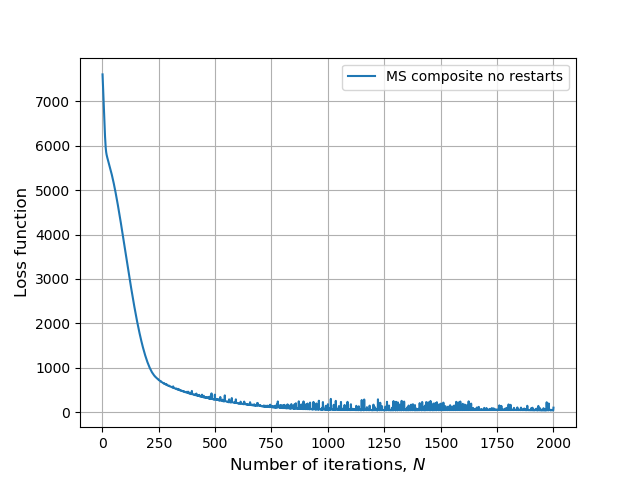

In [117]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, N1 + 1), plt1, label = 'MS composite no restarts')
#plt.plot(range(1, N2 + 1), plt2, label = 'MS composite No gradient for g(x)')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Loss function", fontsize=12)
#plt.title(r"$m + n = 10, \, \delta = 0.003$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()